In [1]:
pip install yfinance pandas matplotlib numpy scikit-learn tensorflow

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error

In [3]:
# Download the data
data = yf.download('AAPL', start='2010-01-01', end='2025-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
data

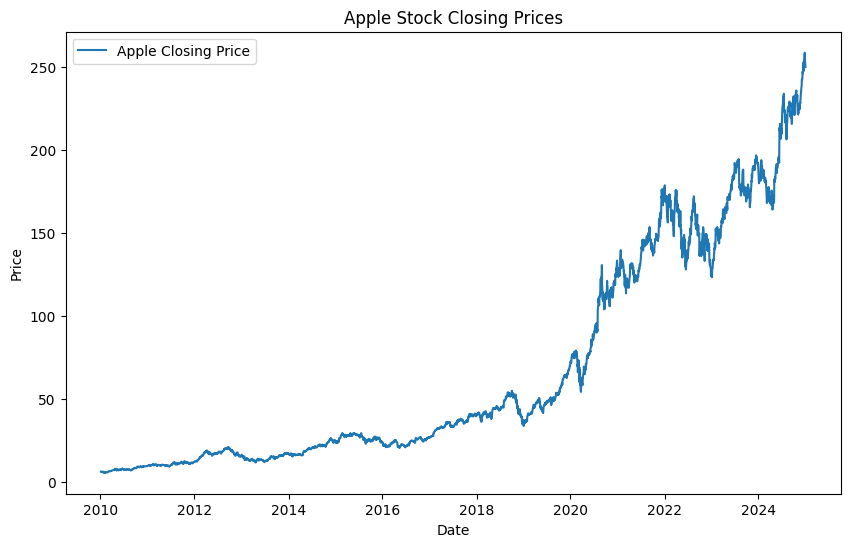

In [4]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close'], label='Apple Closing Price')
plt.title("Apple Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
data

In [5]:
# Data Scaling

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Open'])

In [6]:
scaled_data.shape

(3774, 1)

In [7]:
# Create sequences of 60 days of stock prices as input and the next day as output
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

# Split into train, validation, and test sets (80%, 10%, 10%)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [8]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((2995, 30, 1), (2995, 1), (374, 30, 1), (374, 1), (375, 30, 1), (375, 1))

In [ ]:
X_train,y_train

In [ ]:
# Transformer Model with Encoder Layer and Positional Encoding

class PositionalEncoding(layers.Layer):
    def __init__(self, max_steps=1000, d_model=64, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_steps = max_steps
        self.d_model = d_model
        self.positional_encoding = self._get_positional_encoding(max_steps, d_model)

    def _get_positional_encoding(self, max_steps, d_model):
        pos_enc = np.zeros((max_steps, d_model))
        for pos in range(max_steps):
            for i in range(0, d_model, 2):
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
        return tf.cast(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_steps': self.max_steps,
            'd_model': self.d_model
        })
        return config

# Transformer Encoder Layer
def encoder_layer(units, d_model, num_heads, dropout):
    inputs = layers.Input(shape=(None, d_model))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = layers.Dense(units=units, activation='relu')(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(dropout)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return models.Model(inputs=inputs, outputs=outputs)

# Complete Transformer Model
def transformer_model(seq_len, d_model, num_heads, num_layers, dropout):
    inputs = layers.Input(shape=(seq_len, 1))

    # Embedding
    x = layers.Dense(d_model)(inputs)

    # Positional Encoding
    x = PositionalEncoding(seq_len, d_model)(x)

    # Encoder Layers
    for _ in range(num_layers):
        x = encoder_layer(units=d_model*2, d_model=d_model, num_heads=num_heads, dropout=dropout)(x)

    # Final dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    return models.Model(inputs=inputs, outputs=outputs)

# Set model parameters
d_model = 64
num_heads = 4
num_layers = 2
dropout = 0.1

model = transformer_model(sequence_length, d_model, num_heads, num_layers, dropout)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ModelCheckpoint to save the model with the best validation MAE
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Define Learning Rate Scheduler (Reduce LR when a plateau is reached)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

model.summary()

# Compile the model (this part remains the same)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model with early stopping, checkpoint, and learning rate scheduling
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


In [ ]:
# Recreate model and load weights
from tensorflow.keras import models, layers, optimizers

d_model = 64
num_heads = 4
num_layers = 2
dropout = 0.1
sequence_length = 30

# Recreate the model
new_model = transformer_model(sequence_length, d_model, num_heads, num_layers, dropout)

# Try to load just the weights
try:
    new_model.load_weights('best_model.h5')
    print("Weights loaded successfully!")
    model = new_model
except Exception as e:
    print(f"Error loading weights: {e}")

Weights loaded successfully!


In [ ]:
# Evaluate the model
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
# Function to calculate MAE and MAPE
def evaluate_mae_mape(y_true, y_pred):
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mae, mape

# Inverse transform to original scale
train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate for training data
train_mae, train_mape = evaluate_mae_mape(y_train, train_pred)
print(f"Training Data - MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")

# Evaluate for validation data
val_mae, val_mape = evaluate_mae_mape(y_val, val_pred)
print(f"Validation Data - MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

# Evaluate for test data
test_mae, test_mape = evaluate_mae_mape(y_test, test_pred)
print(f"Test Data - MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training Data - MAE: 2.6502, MAPE: 13.19%
Validation Data - MAE: 2.5375, MAPE: 1.67%
Test Data - MAE: 8.2392, MAPE: 3.77%


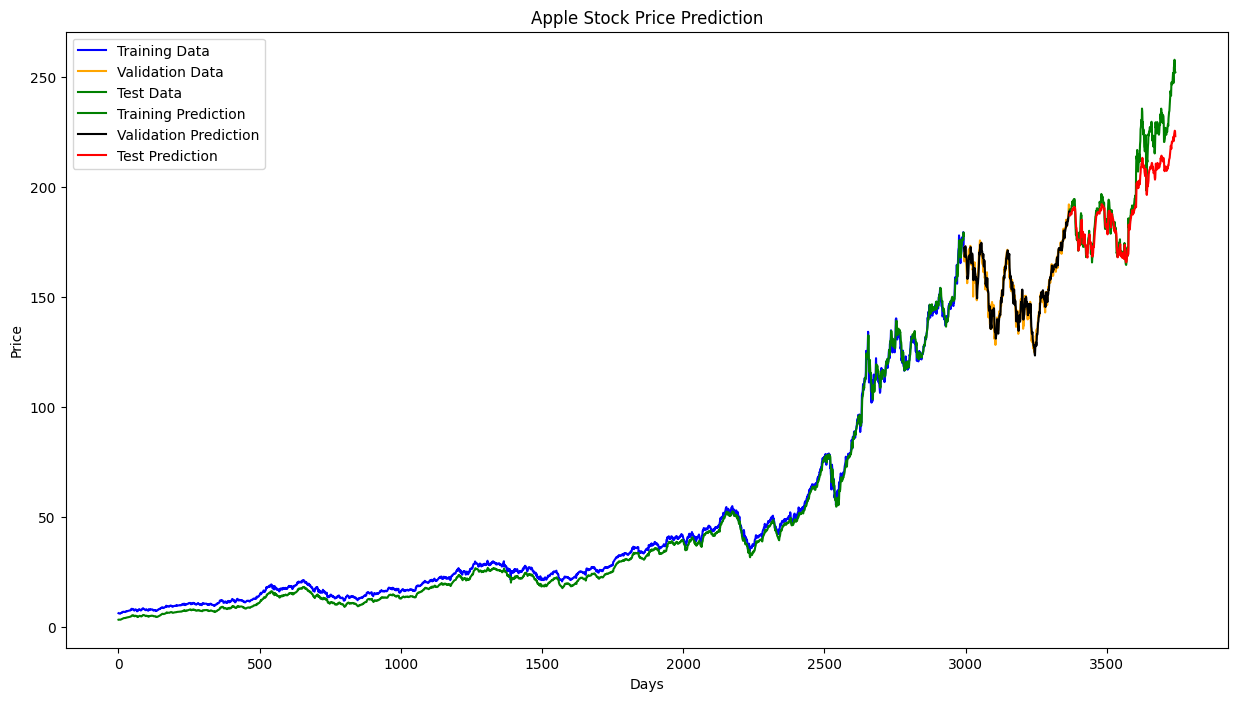

In [ ]:
# Plot results
plt.figure(figsize=(15,8))
plt.plot(np.arange(len(y_train)), y_train, color='blue', label='Training Data')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, color='orange', label='Validation Data')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, color='green', label='Test Data')

plt.plot(np.arange(len(train_pred)), train_pred, color='green', label='Training Prediction')
plt.plot(np.arange(len(y_train), len(y_train) + len(val_pred)), val_pred, color='black', label='Validation Prediction')
plt.plot(np.arange(len(y_train) + len(val_pred), len(y_train) + len(val_pred) + len(test_pred)), test_pred, color='red', label='Test Prediction')

plt.title("Apple Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [14]:

#comparing transformer model with RNN,LSTM,GRU,BiLSTM

def rnn_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.SimpleRNN(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.SimpleRNN(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def lstm_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.LSTM(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.LSTM(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def gru_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.GRU(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.GRU(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def bidirectional_lstm_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Bidirectional(layers.LSTM(units))(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Positional Encoding Layer for Transformer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_steps=1000, d_model=64, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_steps = max_steps
        self.d_model = d_model
        self.positional_encoding = self._get_positional_encoding(max_steps, d_model)

    def _get_positional_encoding(self, max_steps, d_model):
        pos_enc = np.zeros((max_steps, d_model))
        for pos in range(max_steps):
            for i in range(0, d_model, 2):
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
        return tf.cast(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_steps': self.max_steps,
            'd_model': self.d_model
        })
        return config

# Transformer Encoder Layer
def encoder_layer(units, d_model, num_heads, dropout):
    inputs = layers.Input(shape=(None, d_model))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = layers.Dense(units=units, activation='relu')(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(dropout)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return models.Model(inputs=inputs, outputs=outputs)

# Complete Transformer Model function to match the interface of other models
def transformer_model(seq_len, feature_dim=1, units=64):
    # Set transformer-specific parameters
    d_model = units
    num_heads = 4
    num_layers = 2
    dropout = 0.1

    inputs = layers.Input(shape=(seq_len, feature_dim))

    # Embedding
    x = layers.Dense(d_model)(inputs)

    # Positional Encoding
    x = PositionalEncoding(seq_len, d_model)(x)

    # Encoder Layers
    for _ in range(num_layers):
        x = encoder_layer(units=d_model*2, d_model=d_model, num_heads=num_heads, dropout=dropout)(x)

    # Final dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Training function
def train_model(model_func, model_name, X_train, y_train, X_val, y_val, sequence_length, epochs=50, batch_size=32):
    # Create model
    model = model_func(sequence_length)

    # Print model summary
    print(f"\n{'='*50}")
    print(f"Training {model_name} model...")
    print(f"{'='*50}")
    model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_{model_name}_model.h5',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=5,
                                min_lr=1e-6,
                                verbose=1)
    callbacks = [early_stopping, checkpoint, reduce_lr]

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=callbacks
    )

    # Load the best model
    if model_name == 'Transformer':
        new_model = model_func(sequence_length)

        # Trying to load just the weights
        try:
            new_model.load_weights(f'best_{model_name}_model.h5')
            print("Weights loaded successfully!")
            model = new_model
        except Exception as e:
            print(f"Error loading weights: {e}")
            print("Using model with best weights from training session")
    else:
        # Original loading for other models
        model = tf.keras.models.load_model(f'best_{model_name}_model.h5')

    return model, history

# Evaluation function
def evaluate_model(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, scaler):
    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    # Function to calculate MAE and MAPE
    def evaluate_mae_mape(y_true, y_pred):
        # Calculate MAE
        mae = mean_absolute_error(y_true, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        return mae, mape

    # Inverse transform to original scale
    train_pred = scaler.inverse_transform(train_pred)
    val_pred = scaler.inverse_transform(val_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate for training data
    train_mae, train_mape = evaluate_mae_mape(y_train_orig, train_pred)
    print(f"{model_name} - Training Data - MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")

    # Evaluate for validation data
    val_mae, val_mape = evaluate_mae_mape(y_val_orig, val_pred)
    print(f"{model_name} - Validation Data - MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

    # Evaluate for test data
    test_mae, test_mape = evaluate_mae_mape(y_test_orig, test_pred)
    print(f"{model_name} - Test Data - MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")

    results = {
        'train_pred': train_pred,
        'val_pred': val_pred,
        'test_pred': test_pred,
        'y_train': y_train_orig,
        'y_val': y_val_orig,
        'y_test': y_test_orig,
        'metrics': {
            'train_mae': train_mae,
            'train_mape': train_mape,
            'val_mae': val_mae,
            'val_mape': val_mape,
            'test_mae': test_mae,
            'test_mape': test_mape
        }
    }

    return results

# Visualization function
def plot_predictions(results, model_name, stock_name="Stock"):
    # Extract data
    y_train = results['y_train']
    y_val = results['y_val']
    y_test = results['y_test']
    train_pred = results['train_pred']
    val_pred = results['val_pred']
    test_pred = results['test_pred']

    # Plot results
    plt.figure(figsize=(15, 8))

    # Actual data
    plt.plot(np.arange(len(y_train)), y_train, color='blue', label='Training Data')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, color='orange', label='Validation Data')
    plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)),
             y_test, color='green', label='Test Data')

    # Predictions
    plt.plot(np.arange(len(train_pred)), train_pred, color='lightgreen', linestyle='--', label='Training Prediction')
    plt.plot(np.arange(len(y_train), len(y_train) + len(val_pred)),
             val_pred, color='black', linestyle='--', label='Validation Prediction')
    plt.plot(np.arange(len(y_train) + len(val_pred), len(y_train) + len(val_pred) + len(test_pred)),
             test_pred, color='red', linestyle='--', label='Test Prediction')

    plt.title(f"{stock_name} Price Prediction using {model_name}")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_prediction.png")
    plt.show()

# Compare model performances
def compare_models(model_results, stock_name="Stock"):
    models = list(model_results.keys())

    # Create metrics dataframe
    metrics_data = []
    for model_name, results in model_results.items():
        metrics = results['metrics']
        metrics_data.append({
            'Model': model_name,
            'Train MAE': metrics['train_mae'],
            'Train MAPE (%)': metrics['train_mape'],
            'Val MAE': metrics['val_mae'],
            'Val MAPE (%)': metrics['val_mape'],
            'Test MAE': metrics['test_mae'],
            'Test MAPE (%)': metrics['test_mape']
        })

    metrics_df = pd.DataFrame(metrics_data)
    print("\nModel Performance Comparison:")
    print(metrics_df)

    # Plot MAE comparison
    plt.figure(figsize=(14, 6))

    # Bar chart for MAE
    plt.subplot(1, 2, 1)
    x = np.arange(len(models))
    width = 0.2

    plt.bar(x - width, [model_results[m]['metrics']['train_mae'] for m in models],
            width, label='Train MAE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mae'] for m in models],
            width, label='Val MAE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mae'] for m in models],
            width, label='Test MAE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.title(f'{stock_name} Price Prediction - MAE Comparison')
    plt.xticks(x, models)
    plt.legend()

    # Bar chart for MAPE
    plt.subplot(1, 2, 2)
    plt.bar(x - width, [model_results[m]['metrics']['train_mape'] for m in models],
            width, label='Train MAPE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mape'] for m in models],
            width, label='Val MAPE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mape'] for m in models],
            width, label='Test MAPE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAPE (%)')
    plt.title(f'{stock_name} Price Prediction - MAPE Comparison')
    plt.xticks(x, models)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{stock_name}_model_comparison.png")
    plt.show()

    return metrics_df

# Main function to run the entire process
def run_models(X_train, y_train, X_val, y_val, X_test, y_test,
               sequence_length, scaler, epochs=50, batch_size=32, stock_name="Apple"):
    # Model architectures dictionary
    model_builders = {
        'RNN': rnn_model,
        'LSTM': lstm_model,
        'GRU': gru_model,
        'BiLSTM': bidirectional_lstm_model,
        'Transformer': transformer_model
    }

    # Train and evaluate all models
    model_results = {}
    for model_name, model_func in model_builders.items():
        # Train
        trained_model, history = train_model(
            model_func, model_name, X_train, y_train, X_val, y_val,
            sequence_length, epochs, batch_size
        )

        # Evaluate
        results = evaluate_model(
            trained_model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, scaler
        )

        # Store results
        model_results[model_name] = results

        # Plot individual model results
        plot_predictions(results, model_name, stock_name)

    # Compare all models
    metrics_df = compare_models(model_results, stock_name)

    return model_results, metrics_df


Training RNN model...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 30, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0228 - mae: 0.0897
Epoch 1: val_loss improved from inf to 0.00509, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0226 - mae: 0.0893 - val_loss: 0.0051 - val_mae: 0.0675 - learning_rate: 0.0010
Epoch 2/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mae: 0.0213
Epoch 2: val_loss improved from 0.00509 to 0.00232, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 0.0023 - val_mae: 0.0439 - learning_rate: 0.0010
Epoch 3/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1663e-04 - mae: 0.0156
Epoch 3: val_loss improved from 0.00232 to 0.00150, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1697e-04 - mae: 0.0156 - val_loss: 0.0015 - val_mae: 0.0345 - learning_rate: 0.0010
Epoch 4/50
86/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8717e-04 - mae: 0.0150
Epoch 4: val_loss did not improve from 0.00150
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8107e-04 - mae: 0.0149 - val_loss: 0.0022 - val_mae: 0.0433 - learning_rate: 0.0010
Epoch 5/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7594e-04 - mae: 0.0129
Epoch 5: val_loss improved from 0.00150 to 0.00072, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7247e-04 - mae: 0.0129 - val_loss: 7.2184e-04 - val_mae: 0.0225 - learning_rate: 0.0010
Epoch 6/50
86/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8197e-04 - mae: 0.0115
Epoch 6: val_loss did not improve from 0.00072
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8091e-04 - mae: 0.0115 - val_loss: 7.2928e-04 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 7/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7212e-04 - mae: 0.0112
Epoch 7: val_loss did not improve from 0.00072
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7227e-04 - mae: 0.0112 - val_loss: 0.0022 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3230e-04 - mae: 0.0112
Epoch 8: val_loss improved from 0.00072 to 0.00058, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3206e-04 - mae: 0.0112 - val_loss: 5.8448e-04 - val_mae: 0.0204 - learning_rate: 0.0010
Epoch 9/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4249e-04 - mae: 0.0094
Epoch 9: val_loss did not improve from 0.00058
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4405e-04 - mae: 0.0095 - val_loss: 0.0011 - val_mae: 0.0289 - learning_rate: 0.0010
Epoch 10/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0271e-04 - mae: 0.0102
Epoch 10: val_loss improved from 0.00058 to 0.00049, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0156e-04 - mae: 0.0102 - val_loss: 4.8575e-04 - val_mae: 0.0172 - learning_rate: 0.0010
Epoch 11/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6818e-04 - mae: 0.0094
Epoch 11: val_loss did not improve from 0.00049
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6725e-04 - mae: 0.0094 - val_loss: 5.0755e-04 - val_mae: 0.0188 - learning_rate: 0.0010
Epoch 12/50
86/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0021e-04 - mae: 0.0097
Epoch 12: val_loss improved from 0.00049 to 0.00033, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9946e-04 - mae: 0.0097 - val_loss: 3.2501e-04 - val_mae: 0.0143 - learning_rate: 0.0010
Epoch 13/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3528e-04 - mae: 0.0091
Epoch 13: val_loss did not improve from 0.00033
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3476e-04 - mae: 0.0091 - val_loss: 5.3098e-04 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 14/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0252e-04 - mae: 0.0082
Epoch 14: val_loss did not improve from 0.00033
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0229e-04 - mae: 0.0082 - val_loss: 9.9222e-04 - val_mae: 0.0278 - learning_rate: 0.0010
Epoch 15/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7995e-04 - mae: 0.0077
Epoch 15: val_loss did not improve from 0.00033
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7995e-04 - mae: 0.0077 - val_loss: 5.6387e-04 - val_mae: 0.0200 - learning_rate: 0.0010
Epoch 16/50
86/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - los

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
RNN - Training Data - MAE: 1.1782, MAPE: 3.35%
RNN - Validation Data - MAE: 3.5962, MAPE: 2.38%
RNN - Test Data - MAE: 8.8145, MAPE: 4.11%


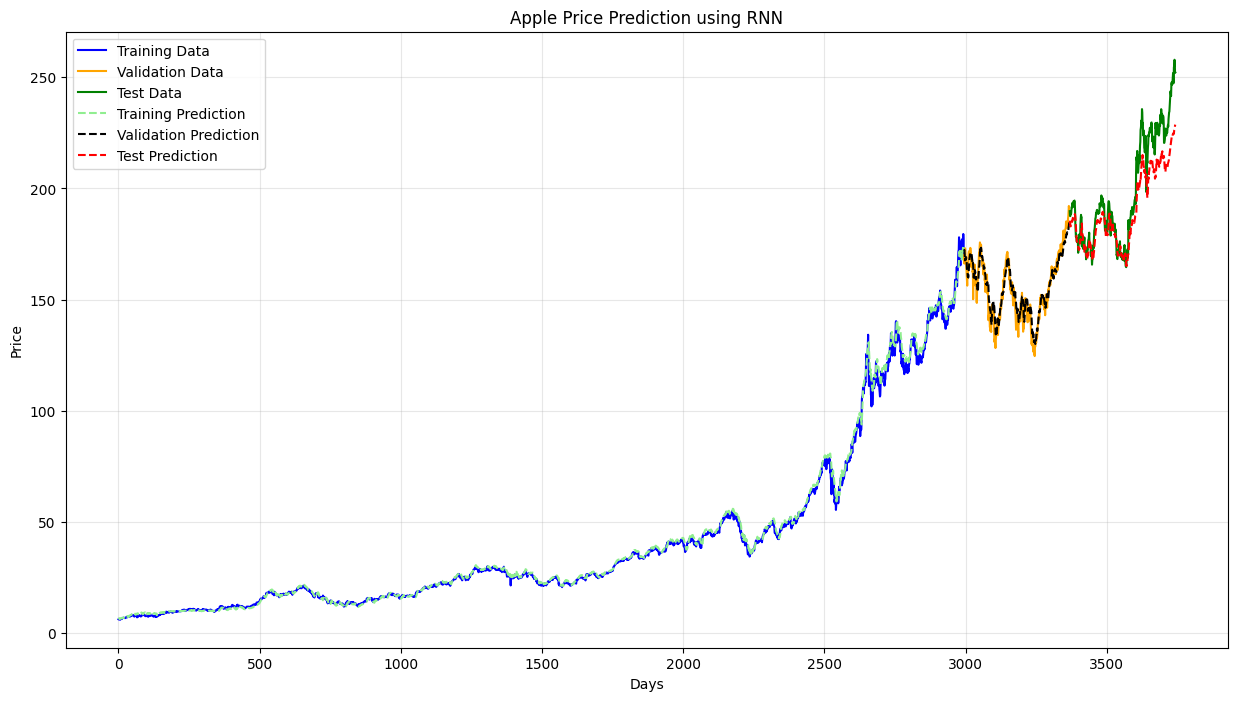


Training LSTM model...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - mae: 0.0405
Epoch 1: val_loss improved from inf to 0.00119, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0055 - mae: 0.0395 - val_loss: 0.0012 - val_mae: 0.0269 - learning_rate: 0.0010
Epoch 2/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5280e-04 - mae: 0.0091
Epoch 2: val_loss improved from 0.00119 to 0.00075, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5291e-04 - mae: 0.0091 - val_loss: 7.5372e-04 - val_mae: 0.0234 - learning_rate: 0.0010
Epoch 3/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6520e-04 - mae: 0.0094
Epoch 3: val_loss did not improve from 0.00075
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6427e-04 - mae: 0.0094 - val_loss: 8.5291e-04 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 4/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0236e-04 - mae: 0.0081
Epoch 4: val_loss did not improve from 0.00075
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0316e-04 - mae: 0.0082 - val_loss: 7.7818e-04 - val_mae: 0.0222 - learning_rate: 0.0010
Epoch 5/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9238e-04 - mae: 0.0084
Epoch 5: val_loss did not improve from 0.00075
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9278e-04 - mae: 0.0084 - val_loss: 0.0011 - val_mae: 0.0282 - learning_rate: 0.0010
Epoch 6/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.838

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1583e-04 - mae: 0.0089 - val_loss: 5.9009e-04 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8670e-04 - mae: 0.0082
Epoch 8: val_loss did not improve from 0.00059
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8678e-04 - mae: 0.0082 - val_loss: 7.2484e-04 - val_mae: 0.0210 - learning_rate: 0.0010
Epoch 9/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6232e-04 - mae: 0.0073
Epoch 9: val_loss did not improve from 0.00059
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6234e-04 - mae: 0.0073 - val_loss: 9.8486e-04 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 10/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5573e-04 - mae: 0.0074
Epoch 10: val_loss did not improve from 0.00059
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5555e-04 - mae: 0.0074 - val_loss: 6.5482e-04 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 11/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6684e-04 - mae: 0.0075 - val_loss: 5.0180e-04 - val_mae: 0.0190 - learning_rate: 0.0010
Epoch 13/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3718e-04 - mae: 0.0065
Epoch 13: val_loss improved from 0.00050 to 0.00046, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3744e-04 - mae: 0.0065 - val_loss: 4.6034e-04 - val_mae: 0.0173 - learning_rate: 5.0000e-04
Epoch 14/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3379e-04 - mae: 0.0067
Epoch 14: val_loss improved from 0.00046 to 0.00045, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.3369e-04 - mae: 0.0067 - val_loss: 4.5116e-04 - val_mae: 0.0173 - learning_rate: 5.0000e-04
Epoch 15/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2018e-04 - mae: 0.0065
Epoch 15: val_loss did not improve from 0.00045
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2044e-04 - mae: 0.0065 - val_loss: 4.7124e-04 - val_mae: 0.0183 - learning_rate: 5.0000e-04
Epoch 16/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3398e-04 - mae: 0.0067
Epoch 16: val_loss did not improve from 0.00045
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3390e-04 - mae: 0.0067 - val_loss: 4.9182e-04 - val_mae: 0.0187 - learning_rate: 5.0000e-04
Epoch 17/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3666e-04 - mae: 0.0071
Epoch 17: val_loss did not improve from 0.00045
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3718e-04 - mae: 0.0071 - val_loss: 5.7363e-04 - val_mae: 0.0202 - learning_rate: 5.0000e-04
Epoch 18/50
88/94 ━━━━━━━━━━━━━━━━━━━


Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2731e-04 - mae: 0.0064 - val_loss: 4.1917e-04 - val_mae: 0.0170 - learning_rate: 5.0000e-04
Epoch 19/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1706e-04 - mae: 0.0063
Epoch 19: val_loss did not improve from 0.00042
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1698e-04 - mae: 0.0063 - val_loss: 4.2532e-04 - val_mae: 0.0172 - learning_rate: 2.5000e-04
Epoch 20/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1979e-04 - mae: 0.0060
Epoch 20: val_loss did not improve from 0.00042
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1956e-04 - mae: 0.0060 - val_loss: 5.7414e-04 - val_mae: 0.0201 - learning_rate: 2.5000e-04
Epoch 21/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7919e-05 - mae: 0.0057
Epoch 21: val_loss did not improve from 0.00042
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8993e-05 - mae: 0.0058 - val_loss: 4.4207e-04 - val_ma

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM - Training Data - MAE: 1.1700, MAPE: 3.43%
LSTM - Validation Data - MAE: 4.2860, MAPE: 2.81%
LSTM - Test Data - MAE: 5.1648, MAPE: 2.54%


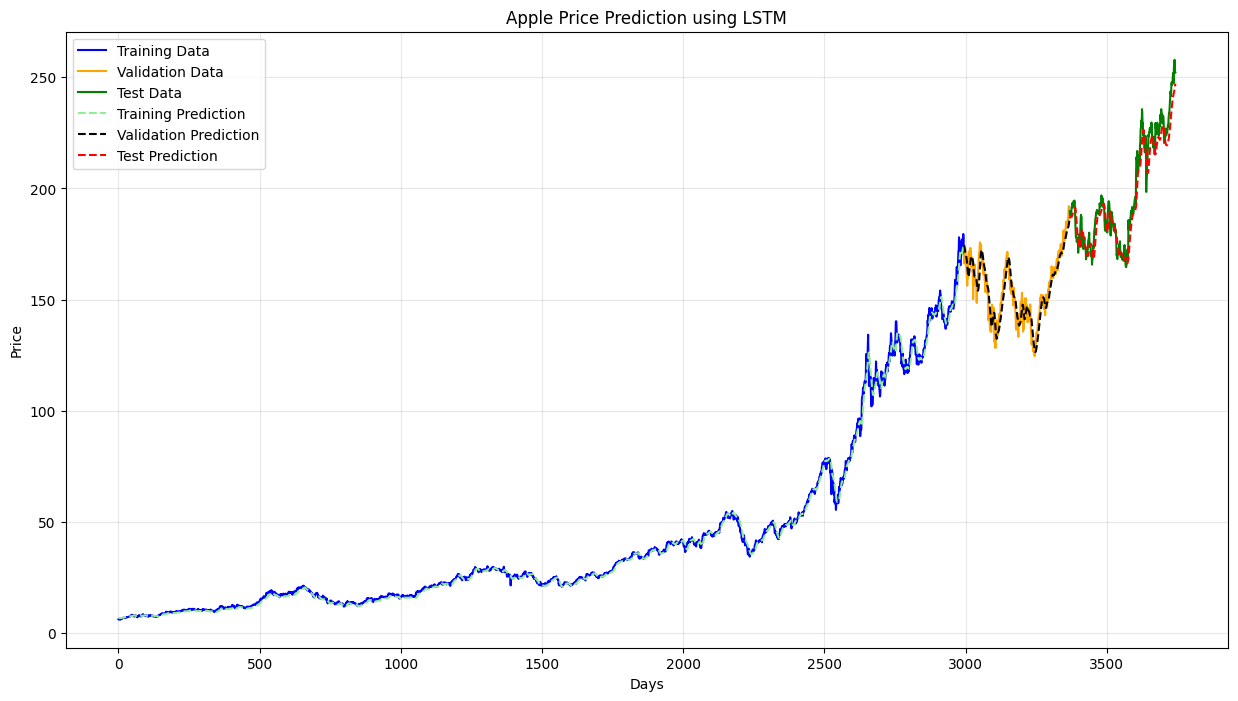


Training GRU model...


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 30, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,937 (156.00 KB)

 Trainable params: 39,937 (156.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - mae: 0.0500
Epoch 1: val_loss improved from inf to 0.00034, saving model to best_GRU_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0081 - mae: 0.0481 - val_loss: 3.4463e-04 - val_mae: 0.0154 - learning_rate: 0.0010
Epoch 2/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6573e-04 - mae: 0.0096
Epoch 2: val_loss did not improve from 0.00034
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6518e-04 - mae: 0.0096 - val_loss: 8.2858e-04 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 3/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0511e-04 - mae: 0.0080
Epoch 3: val_loss did not improve from 0.00034
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0555e-04 - mae: 0.0080 - val_loss: 3.8460e-04 - val_mae: 0.0164 - learning_rate: 0.0010
Epoch 4/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7095e-04 - mae: 0.0077
Epoch 4: val_loss did not improve from 0.00034
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7121e-04 - mae: 0.0077 - val_loss: 0.0019 - val_mae: 0.0399 - learning_rate: 0.0010
Epoch 5/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0124e-04 


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7418e-04 - mae: 0.0076 - val_loss: 2.7221e-04 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 7/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4208e-04 - mae: 0.0066
Epoch 7: val_loss did not improve from 0.00027
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4200e-04 - mae: 0.0066 - val_loss: 8.0414e-04 - val_mae: 0.0248 - learning_rate: 5.0000e-04
Epoch 8/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1409e-04 - mae: 0.0061
Epoch 8: val_loss did not improve from 0.00027
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1456e-04 - mae: 0.0061 - val_loss: 6.9618e-04 - val_mae: 0.0228 - learning_rate: 5.0000e-04
Epoch 9/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1359e-04 - mae: 0.0065
Epoch 9: val_loss did not improve from 0.00027
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1336e-04 - mae: 0.0065 - val_loss: 3.4355e-04 - val_mae: 0.0

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
GRU - Training Data - MAE: 0.9706, MAPE: 3.29%
GRU - Validation Data - MAE: 3.3446, MAPE: 2.20%
GRU - Test Data - MAE: 3.5703, MAPE: 1.79%


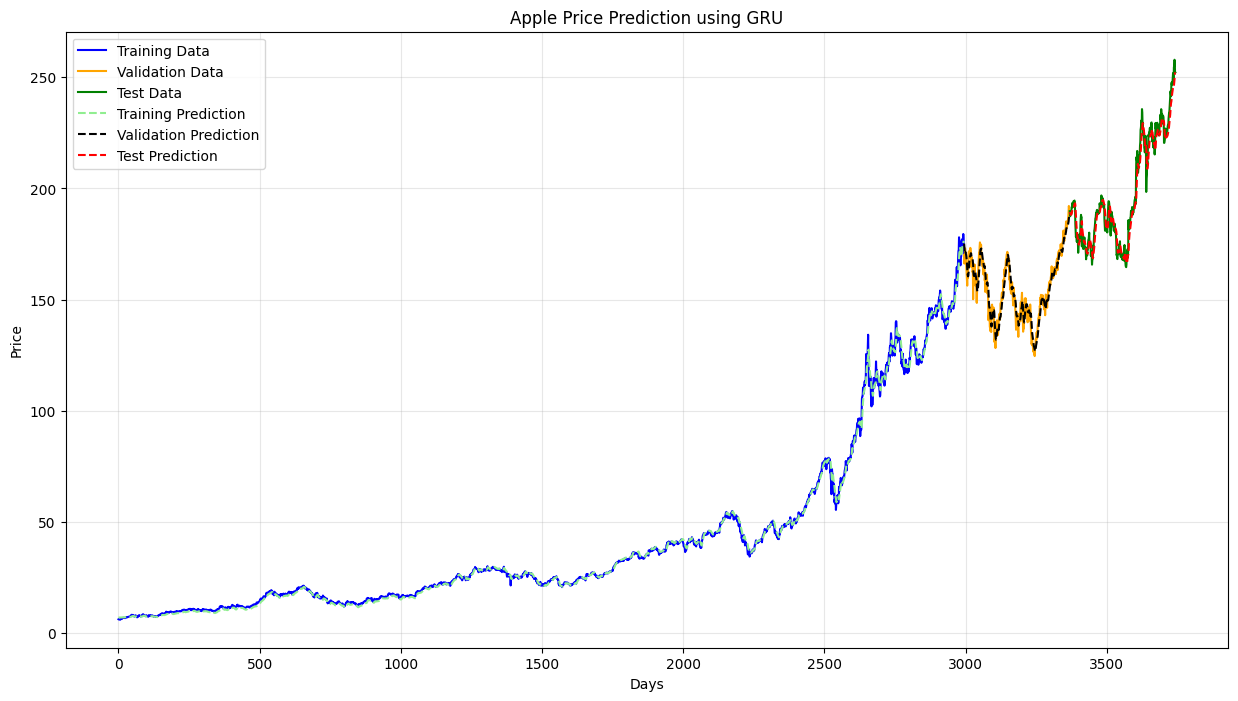


Training BiLSTM model...


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 30, 128)             │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,769 (534.25 KB)

 Trainable params: 136,769 (534.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - mae: 0.0300
Epoch 1: val_loss improved from inf to 0.00117, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0033 - mae: 0.0296 - val_loss: 0.0012 - val_mae: 0.0279 - learning_rate: 0.0010
Epoch 2/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7603e-04 - mae: 0.0099
Epoch 2: val_loss did not improve from 0.00117
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7434e-04 - mae: 0.0099 - val_loss: 0.0018 - val_mae: 0.0331 - learning_rate: 0.0010
Epoch 3/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9458e-04 - mae: 0.0087
Epoch 3: val_loss improved from 0.00117 to 0.00073, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.9480e-04 - mae: 0.0087 - val_loss: 7.2603e-04 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 4/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3277e-04 - mae: 0.0097
Epoch 4: val_loss improved from 0.00073 to 0.00065, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.3345e-04 - mae: 0.0097 - val_loss: 6.5422e-04 - val_mae: 0.0215 - learning_rate: 0.0010
Epoch 5/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2127e-04 - mae: 0.0093
Epoch 5: val_loss did not improve from 0.00065
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.2049e-04 - mae: 0.0093 - val_loss: 0.0012 - val_mae: 0.0271 - learning_rate: 0.0010
Epoch 6/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4726e-04 - mae: 0.0076
Epoch 6: val_loss did not improve from 0.00065
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.4758e-04 - mae: 0.0076 - val_loss: 0.0011 - val_mae: 0.0285 - learning_rate: 0.0010
Epoch 7/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8401e-04 - mae: 0.0083
Epoch 7: val_loss improved from 0.00065 to 0.00041, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8352e-04 - mae: 0.0083 - val_loss: 4.1475e-04 - val_mae: 0.0164 - learning_rate: 0.0010
Epoch 8/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4487e-04 - mae: 0.0072
Epoch 8: val_loss improved from 0.00041 to 0.00041, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.4430e-04 - mae: 0.0072 - val_loss: 4.1328e-04 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 9/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2549e-04 - mae: 0.0066
Epoch 9: val_loss improved from 0.00041 to 0.00037, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2563e-04 - mae: 0.0066 - val_loss: 3.6845e-04 - val_mae: 0.0154 - learning_rate: 0.0010
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2901e-04 - mae: 0.0068
Epoch 10: val_loss did not improve from 0.00037
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2915e-04 - mae: 0.0068 - val_loss: 9.3374e-04 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 11/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2679e-04 - mae: 0.0067
Epoch 11: val_loss improved from 0.00037 to 0.00035, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.2670e-04 - mae: 0.0067 - val_loss: 3.4678e-04 - val_mae: 0.0151 - learning_rate: 0.0010
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2690e-04 - mae: 0.0068
Epoch 12: val_loss did not improve from 0.00035

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2696e-04 - mae: 0.0068 - val_loss: 0.0012 - val_mae: 0.0294 - learning_rate: 0.0010
Epoch 13/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1963e-04 - mae: 0.0066
Epoch 13: val_loss improved from 0.00035 to 0.00034, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1958e-04 - mae: 0.0066 - val_loss: 3.4238e-04 - val_mae: 0.0150 - learning_rate: 5.0000e-04
Epoch 14/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2859e-05 - mae: 0.0058
Epoch 14: val_loss improved from 0.00034 to 0.00033, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.2978e-05 - mae: 0.0058 - val_loss: 3.2695e-04 - val_mae: 0.0145 - learning_rate: 5.0000e-04
Epoch 15/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0593e-04 - mae: 0.0060
Epoch 15: val_loss did not improve from 0.00033
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0570e-04 - mae: 0.0060 - val_loss: 5.0409e-04 - val_mae: 0.0188 - learning_rate: 5.0000e-04
Epoch 16/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6107e-05 - mae: 0.0057
Epoch 16: val_loss did not improve from 0.00033
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.6163e-05 - mae: 0.0057 - val_loss: 3.3326e-04 - val_mae: 0.0142 - learning_rate: 5.0000e-04
Epoch 17/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1762e-05 - mae: 0.0062
Epoch 17: val_loss improved from 0.00033 to 0.00032, saving model to best_BiLSTM_model.h5



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2034e-05 - mae: 0.0062 - val_loss: 3.1681e-04 - val_mae: 0.0139 - learning_rate: 5.0000e-04
Epoch 18/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.4057e-05 - mae: 0.0049
Epoch 18: val_loss did not improve from 0.00032
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 7.4266e-05 - mae: 0.0049 - val_loss: 3.6010e-04 - val_mae: 0.0155 - learning_rate: 2.5000e-04
Epoch 19/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9892e-05 - mae: 0.0055
Epoch 19: val_loss improved from 0.00032 to 0.00030, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9739e-05 - mae: 0.0055 - val_loss: 3.0056e-04 - val_mae: 0.0136 - learning_rate: 2.5000e-04
Epoch 20/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0838e-04 - mae: 0.0060
Epoch 20: val_loss did not improve from 0.00030
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0829e-04 - mae: 0.0060 - val_loss: 3.0147e-04 - val_mae: 0.0137 - learning_rate: 2.5000e-04
Epoch 21/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6870e-05 - mae: 0.0054
Epoch 21: val_loss did not improve from 0.00030
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.6740e-05 - mae: 0.0054 - val_loss: 3.1931e-04 - val_mae: 0.0143 - learning_rate: 2.5000e-04
Epoch 22/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0028e-05 - mae: 0.0051
Epoch 22: val_loss did not improve from 0.00030
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.0234e-05 - mae: 0.0051 - val_loss: 3.0431e-04 - val_mae: 0.0137 - learning_rate: 2.5000e-04
Epoch 23/50
92/94 ━━━━━━━━━━━━━━━

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.0592e-05 - mae: 0.0050 - val_loss: 2.9903e-04 - val_mae: 0.0134 - learning_rate: 1.2500e-04
Epoch 27/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.4428e-05 - mae: 0.0050
Epoch 27: val_loss did not improve from 0.00030
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.4474e-05 - mae: 0.0050 - val_loss: 3.3932e-04 - val_mae: 0.0141 - learning_rate: 1.2500e-04
Epoch 28/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1079e-05 - mae: 0.0052
Epoch 28: val_loss did not improve from 0.00030
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.0965e-05 - mae: 0.0052 - val_loss: 3.5099e-04 - val_mae: 0.0144 - learning_rate: 1.2500e-04
Epoch 29/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6854e-05 - mae: 0.0049
Epoch 29: val_loss did not improve from 0.00030

Epoch 29: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.6729e-05 - mae: 0.0049 - val_loss: 3.0119e-04 - 

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.7638e-05 - mae: 0.0049 - val_loss: 2.9635e-04 - val_mae: 0.0134 - learning_rate: 6.2500e-05
Epoch 34/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4812e-05 - mae: 0.0052
Epoch 34: val_loss did not improve from 0.00030

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.4691e-05 - mae: 0.0052 - val_loss: 4.4257e-04 - val_mae: 0.0175 - learning_rate: 6.2500e-05
Epoch 35/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.8789e-05 - mae: 0.0049
Epoch 35: val_loss improved from 0.00030 to 0.00029, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.8664e-05 - mae: 0.0049 - val_loss: 2.9333e-04 - val_mae: 0.0135 - learning_rate: 3.1250e-05
Epoch 36/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2414e-05 - mae: 0.0047
Epoch 36: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2530e-05 - mae: 0.0047 - val_loss: 3.6164e-04 - val_mae: 0.0155 - learning_rate: 3.1250e-05
Epoch 37/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4136e-05 - mae: 0.0051
Epoch 37: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.3957e-05 - mae: 0.0051 - val_loss: 3.1108e-04 - val_mae: 0.0141 - learning_rate: 3.1250e-05
Epoch 38/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7936e-05 - mae: 0.0048
Epoch 38: val_loss improved from 0.00029 to 0.00028, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8005e-05 - mae: 0.0048 - val_loss: 2.8474e-04 - val_mae: 0.0132 - learning_rate: 3.1250e-05
Epoch 39/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0428e-05 - mae: 0.0045
Epoch 39: val_loss did not improve from 0.00028

Epoch 39: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.0845e-05 - mae: 0.0045 - val_loss: 3.3212e-04 - val_mae: 0.0147 - learning_rate: 3.1250e-05
Epoch 40/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0854e-05 - mae: 0.0045
Epoch 40: val_loss did not improve from 0.00028
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.0874e-05 - mae: 0.0045 - val_loss: 2.9817e-04 - val_mae: 0.0137 - learning_rate: 1.5625e-05
Epoch 41/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8882e-05 - mae: 0.0048
Epoch 41: val_loss did not improve from 0.00028
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8911e-05 - mae: 0.0048 - val_loss: 3.0938e-04 

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.6201e-05 - mae: 0.0048 - val_loss: 2.8277e-04 - val_mae: 0.0132 - learning_rate: 1.5625e-05
Epoch 44/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5619e-05 - mae: 0.0049
Epoch 44: val_loss did not improve from 0.00028

Epoch 44: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.5498e-05 - mae: 0.0049 - val_loss: 2.8819e-04 - val_mae: 0.0134 - learning_rate: 1.5625e-05
Epoch 45/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5362e-05 - mae: 0.0050
Epoch 45: val_loss did not improve from 0.00028
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.5332e-05 - mae: 0.0050 - val_loss: 3.1827e-04 - val_mae: 0.0143 - learning_rate: 7.8125e-06
Epoch 46/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0931e-05 - mae: 0.0047
Epoch 46: val_loss did not improve from 0.00028
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.0809e-05 - mae: 0.0047 - val_loss: 3.3488e-04 -

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
BiLSTM - Training Data - MAE: 0.8281, MAPE: 2.23%
BiLSTM - Validation Data - MAE: 3.3241, MAPE: 2.18%
BiLSTM - Test Data - MAE: 3.4371, MAPE: 1.74%


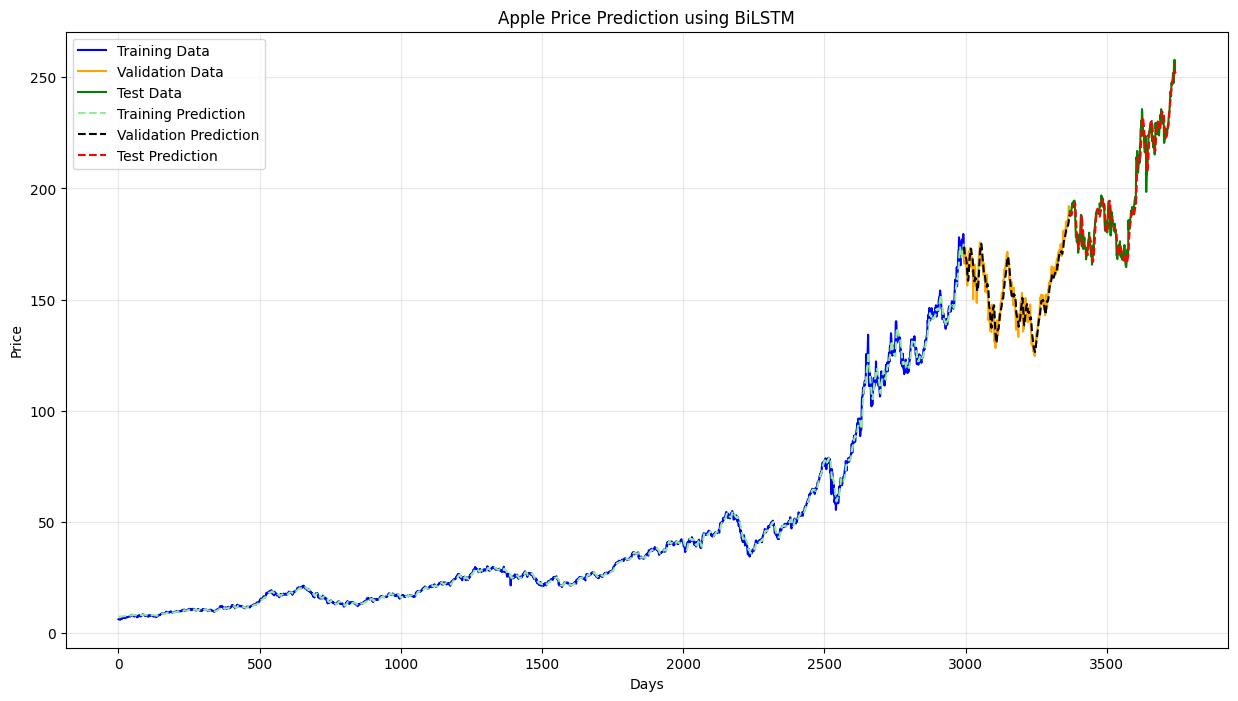


Training Transformer model...


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 30, 64)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_1                │ (None, 30, 64)              │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_12 (Functional)           │ (None, 30, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_13 (Functional)           │ (None, 30, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,641 (658.75 KB)

 Trainable params: 168,641 (658.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1845 - mae: 0.1854
Epoch 1: val_loss improved from inf to 0.00220, saving model to best_Transformer_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - loss: 0.1830 - mae: 0.1843 - val_loss: 0.0022 - val_mae: 0.0368 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - mae: 0.0268
Epoch 2: val_loss did not improve from 0.00220
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0011 - mae: 0.0268 - val_loss: 0.0026 - val_mae: 0.0407 - learning_rate: 0.0010
Epoch 3/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0002e-04 - mae: 0.0239
Epoch 3: val_loss did not improve from 0.00220
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0225e-04 - mae: 0.0240 - val_loss: 0.0030 - val_mae: 0.0452 - learning_rate: 0.0010
Epoch 4/50
84/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0312
Epoch 4: val_loss improved from 0.00220 to 0.00130, saving model to best_Transformer_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - mae: 0.0305 - val_loss: 0.0013 - val_mae: 0.0306 - learning_rate: 0.0010
Epoch 5/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4463e-04 - mae: 0.0230
Epoch 5: val_loss did not improve from 0.00130
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4669e-04 - mae: 0.0230 - val_loss: 0.0015 - val_mae: 0.0305 - learning_rate: 0.0010
Epoch 6/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8986e-04 - mae: 0.0190
Epoch 6: val_loss did not improve from 0.00130
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9288e-04 - mae: 0.0190 - val_loss: 0.0031 - val_mae: 0.0458 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6144e-04 - mae: 0.0222
Epoch 7: val_loss improved from 0.00130 to 0.00116, saving model to best_Transformer_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6137e-04 - mae: 0.0222 - val_loss: 0.0012 - val_mae: 0.0281 - learning_rate: 0.0010
Epoch 8/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5946e-04 - mae: 0.0187
Epoch 8: val_loss did not improve from 0.00116
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5892e-04 - mae: 0.0187 - val_loss: 0.0020 - val_mae: 0.0356 - learning_rate: 0.0010
Epoch 9/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1507e-04 - mae: 0.0156
Epoch 9: val_loss did not improve from 0.00116
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1584e-04 - mae: 0.0156 - val_loss: 0.0016 - val_mae: 0.0317 - learning_rate: 0.0010
Epoch 10/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9627e-04 - mae: 0.0155
Epoch 10: val_loss did not improve from 0.00116
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9696e-04 - mae: 0.0155 - val_loss: 0.0024 - val_mae: 0.0408 - learning_rate: 0.0010
Epoch 11/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0273e-04 - mae:

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9498e-04 - mae: 0.0176 - val_loss: 8.7042e-04 - val_mae: 0.0234 - learning_rate: 0.0010
Epoch 12/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0457e-04 - mae: 0.0137
Epoch 12: val_loss did not improve from 0.00087
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0680e-04 - mae: 0.0137 - val_loss: 0.0020 - val_mae: 0.0377 - learning_rate: 0.0010
Epoch 13/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4010e-04 - mae: 0.0166
Epoch 13: val_loss improved from 0.00087 to 0.00076, saving model to best_Transformer_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3756e-04 - mae: 0.0166 - val_loss: 7.6370e-04 - val_mae: 0.0214 - learning_rate: 0.0010
Epoch 14/50
84/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6420e-04 - mae: 0.0126
Epoch 14: val_loss did not improve from 0.00076
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7982e-04 - mae: 0.0129 - val_loss: 9.3878e-04 - val_mae: 0.0261 - learning_rate: 0.0010
Epoch 15/50
85/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1691e-04 - mae: 0.0143
Epoch 15: val_loss did not improve from 0.00076
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1265e-04 - mae: 0.0142 - val_loss: 9.7802e-04 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 16/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4507e-04 - mae: 0.0122
Epoch 16: val_loss improved from 0.00076 to 0.00049, saving model to best_Transformer_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4664e-04 - mae: 0.0122 - val_loss: 4.8815e-04 - val_mae: 0.0171 - learning_rate: 0.0010
Epoch 17/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4566e-04 - mae: 0.0170
Epoch 17: val_loss improved from 0.00049 to 0.00032, saving model to best_Transformer_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3834e-04 - mae: 0.0168 - val_loss: 3.2091e-04 - val_mae: 0.0149 - learning_rate: 0.0010
Epoch 18/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7274e-04 - mae: 0.0131
Epoch 18: val_loss did not improve from 0.00032
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7152e-04 - mae: 0.0130 - val_loss: 3.9324e-04 - val_mae: 0.0156 - learning_rate: 0.0010
Epoch 19/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8202e-04 - mae: 0.0107
Epoch 19: val_loss did not improve from 0.00032
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8190e-04 - mae: 0.0106 - val_loss: 0.0011 - val_mae: 0.0296 - learning_rate: 0.0010
Epoch 20/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5444e-04 - mae: 0.0127
Epoch 20: val_loss did not improve from 0.00032
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5128e-04 - mae: 0.0126 - val_loss: 4.5225e-04 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 21/50
85/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1


Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5953e-04 - mae: 0.0099 - val_loss: 2.6411e-04 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 23/50
84/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3890e-04 - mae: 0.0093
Epoch 23: val_loss did not improve from 0.00026
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3622e-04 - mae: 0.0091 - val_loss: 4.5705e-04 - val_mae: 0.0177 - learning_rate: 5.0000e-04
Epoch 24/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0199e-04 - mae: 0.0076
Epoch 24: val_loss did not improve from 0.00026
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0216e-04 - mae: 0.0076 - val_loss: 4.2989e-04 - val_mae: 0.0171 - learning_rate: 5.0000e-04
Epoch 25/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1674e-04 - mae: 0.0084
Epoch 25: val_loss did not improve from 0.00026
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1648e-04 - mae: 0.0084 - val_loss: 6.7281e-04 - val_mae: 0

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0423e-04 - mae: 0.0077 - val_loss: 2.0162e-04 - val_mae: 0.0113 - learning_rate: 5.0000e-04
Epoch 27/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1301e-04 - mae: 0.0082
Epoch 27: val_loss did not improve from 0.00020
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1256e-04 - mae: 0.0081 - val_loss: 5.2462e-04 - val_mae: 0.0194 - learning_rate: 5.0000e-04
Epoch 28/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3329e-04 - mae: 0.0090
Epoch 28: val_loss did not improve from 0.00020
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3262e-04 - mae: 0.0090 - val_loss: 4.4500e-04 - val_mae: 0.0177 - learning_rate: 5.0000e-04
Epoch 29/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2456e-04 - mae: 0.0087
Epoch 29: val_loss did not improve from 0.00020
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2420e-04 - mae: 0.0087 - val_loss: 3.2939e-04 - val_mae: 0.0149 - learning_rate: 5.0000e-04
Epoch 30/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 


Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0934e-04 - mae: 0.0082 - val_loss: 2.0004e-04 - val_mae: 0.0113 - learning_rate: 5.0000e-04
Epoch 32/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8619e-05 - mae: 0.0066
Epoch 32: val_loss did not improve from 0.00020
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8823e-05 - mae: 0.0066 - val_loss: 3.2335e-04 - val_mae: 0.0148 - learning_rate: 2.5000e-04
Epoch 33/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8798e-05 - mae: 0.0072
Epoch 33: val_loss did not improve from 0.00020
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.8734e-05 - mae: 0.0072 - val_loss: 2.1344e-04 - val_mae: 0.0117 - learning_rate: 2.5000e-04
Epoch 34/50
85/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6966e-05 - mae: 0.0070
Epoch 34: val_loss did not improve from 0.00020
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6692e-05 - mae: 0.0070 - val_loss: 2.2641e-04 - val_ma


Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0606e-05 - mae: 0.0067 - val_loss: 1.5578e-04 - val_mae: 0.0098 - learning_rate: 2.5000e-04
Epoch 37/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0166e-04 - mae: 0.0077
Epoch 37: val_loss did not improve from 0.00016
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0145e-04 - mae: 0.0077 - val_loss: 3.4133e-04 - val_mae: 0.0152 - learning_rate: 1.2500e-04
Epoch 38/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5220e-05 - mae: 0.0065
Epoch 38: val_loss did not improve from 0.00016
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5207e-05 - mae: 0.0065 - val_loss: 2.7693e-04 - val_mae: 0.0135 - learning_rate: 1.2500e-04
Epoch 39/50
86/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0832e-05 - mae: 0.0063
Epoch 39: val_loss did not improve from 0.00016
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0868e-05 - mae: 0.0063 - val_loss: 4.2177e-04 - val_ma

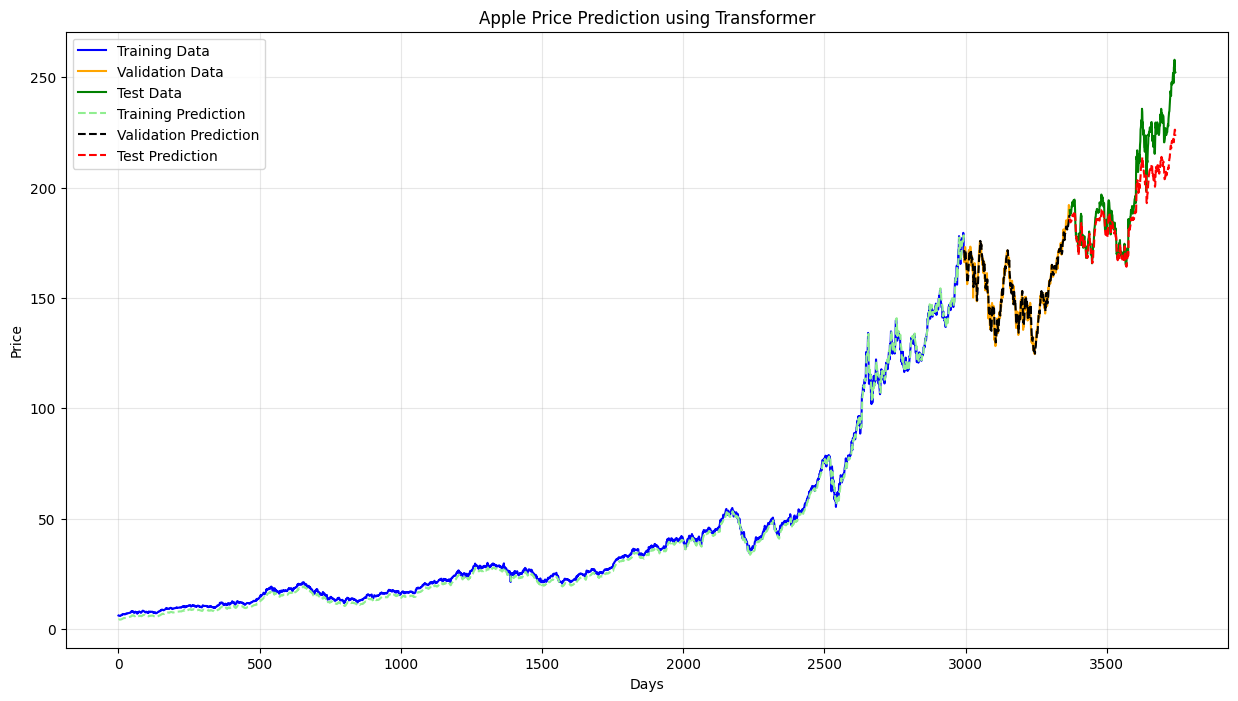


Model Performance Comparison:
         Model  Train MAE  Train MAPE (%)   Val MAE  Val MAPE (%)  Test MAE  \
0          RNN   1.178227        3.351935  3.596246      2.384777  8.814485   
1         LSTM   1.170024        3.430960  4.286013      2.810923  5.164758   
2          GRU   0.970638        3.290523  3.344577      2.204394  3.570265   
3       BiLSTM   0.828125        2.232947  3.324113      2.179802  3.437099   
4  Transformer   1.717110        8.024496  2.463390      1.615145  9.166016   

   Test MAPE (%)  
0       4.112696  
1       2.535122  
2       1.785106  
3       1.743311  
4       4.219495  


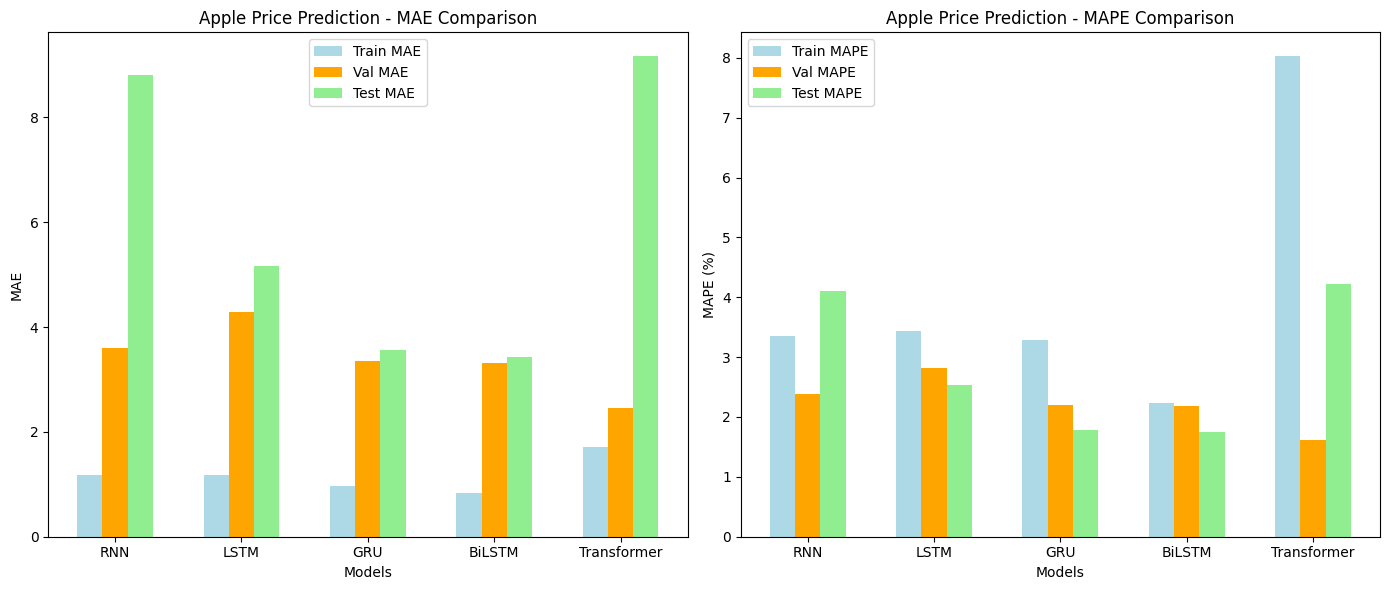

In [15]:
results, metrics = run_models(
    X_train, y_train, X_val, y_val, X_test, y_test,
    sequence_length=sequence_length,
    scaler=scaler,
    epochs=50,
    batch_size=32,
    stock_name="Apple"
)